In [1]:
# General imports
import numpy as np
from time import time
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [2]:
# Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit_ibm_provider import IBMProvider

In [3]:
# Load ibmq_guadalupe device
provider = IBMProvider()

# Real backend; needed for transpilation later on
guadalupe = provider.get_backend("ibmq_guadalupe")

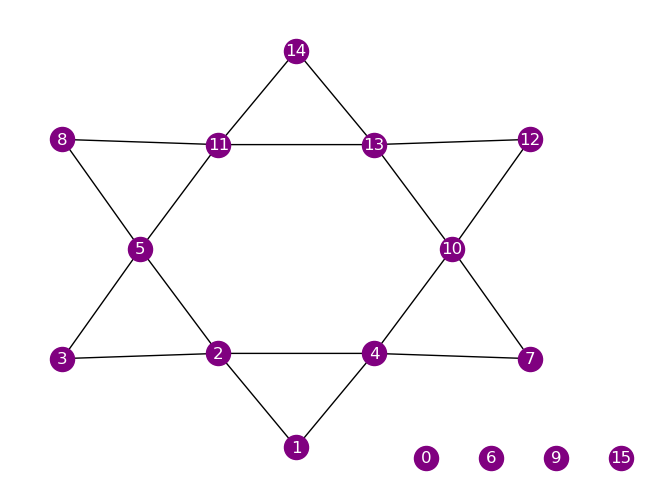

In [4]:
import rustworkx as rx
from qiskit_nature.problems.second_quantization.lattice import Lattice

# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [5]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from heisenberg_model import HeisenbergModel

# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
# ham_16

In [6]:
def W_entangler(circuit,q_array,param_name):
    # takes a quantum circuit and creates a parametrised W state 
    # between the qubits specified in q_array, with parameters specified in a vector param_name
    circuit.x(q_array[0])  # apply NOT to the first qubit in q_array
    k = len(q_array) - 1   # need a number of parameters one less than the number of qubits
    theta = []
    for i in range(k):
        theta.append(Parameter(param_name+'_'+str(i)))
    
    for j in range(k):  # this applies a rotation to qubit at index j+1 in the array 
        circuit.ry(theta[j],q_array[j+1])
        circuit.cz(q_array[j],q_array[j+1])
        circuit.ry(-theta[j],q_array[j+1])
    for j in range(k):  # entangle all the qubits with CNOT gates
        circuit.cx(q_array[j+1],q_array[j])
    return circuit

In [7]:
kagome_ansatz = QuantumCircuit(12)  
# use a quantum circuit of 12 qubits corresponding to the spins in the Kagome lattice

for i in range(5):      
    # create W states between 3 qubits in each of 5 subsequent triangles of the Kagome lattice 
    W_entangler(kagome_ansatz,[2*i+1,(2*i+2)%12,(2*i+3)%12],'t'+str(i))

# entangle the last qubit with the first (still free) qubit in the lattice
W_entangler(kagome_ansatz,[11,0],'t'+str(5))

# kagome_ansatz.draw('mpl')

In [8]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
ansatz = kagome_ansatz

q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(ansatz, backend=guadalupe, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
print(ansatz_opt.parameters)
# ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 77), ('sx', 44), ('cx', 22), ('x', 6)])
number of parameters in the circuit: 11
ParameterView([Parameter(t0_0), Parameter(t0_1), Parameter(t1_0), Parameter(t1_1), Parameter(t2_0), Parameter(t2_1), Parameter(t3_0), Parameter(t3_1), Parameter(t4_0), Parameter(t4_1), Parameter(t5_0)])


In [9]:
from qiskit.algorithms.optimizers import SPSA
optimizer = SPSA(maxiter=100)

In [10]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None, x0=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        # select randon initial parameters for the ansatz if none specified
        if x0 is not None:
            self._x0 = x0 
        else:
            self._x0 = np.pi/2 * (np.random.rand(self._circuit.num_parameters))
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value

        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=self._x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [11]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session, Estimator as RuntimeEstimator, Options)

service = QiskitRuntimeService(channel='ibm_quantum')

In [16]:
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [17]:
backend = 'ibmq_guadalupe'

options = Options()
options.execution.shots = 10000

# x0 = [((i+1)%2) * np.pi/4 + (np.random.rand()-0.5)/5 for i in range(11)]

with Session(service=service,backend=backend) as session:
    rt_estimator = RuntimeEstimator(session=session,options=options)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
print(result)

RuntimeJobFailureError: 'Unable to retrieve job result. Job cgbledai9pt5mcdbt9jg has failed:\nTraceback (most recent call last):\n2023-03-20T08:18:38.911031348Z   File "/provider/server/main.py", line 75, in execute_program\n2023-03-20T08:18:38.911031348Z     starter.execute()\n2023-03-20T08:18:38.911031348Z   File "/provider/programruntime/program_starter_wrapper.py", line 104, in execute\n2023-03-20T08:18:38.911031348Z     raise ex\n2023-03-20T08:18:38.911031348Z   File "/provider/programruntime/program_starter_wrapper.py", line 91, in execute\n2023-03-20T08:18:38.911031348Z     final_result = self.main(backend, self.messenger, **self.user_params)\n2023-03-20T08:18:38.911031348Z   File "/code/program.py", line 1406, in main\n2023-03-20T08:18:38.911031348Z     result = estimator.run(\n2023-03-20T08:18:38.911031348Z   File "/code/program.py", line 269, in run\n2023-03-20T08:18:38.911031348Z     result, metadata = run_circuits(bound_circuits, self._backend, **run_opts.__dict__)\n2023-03-20T08:18:38.911031348Z   File "/code/program.py", line 97, in run_circuits\n2023-03-20T08:18:38.911031348Z     return job.result(), metadata\n2023-03-20T08:18:38.911031348Z   File "/provider/programruntime/runtime_job.py", line 83, in result\n2023-03-20T08:18:38.911031348Z     raise JobError(\n2023-03-20T08:18:38.911031348Z qiskit.providers.exceptions.JobError: \'Unable to retrieve result for job estimator_cgbledai9pt5mcdbt9jg_3df8_0. Job has failed: Internal Error. Error code: 9999.\'\n2023-03-20T08:18:38.916758000Z /pod-data/ CLOSE_WRITE,CLOSE terminated\n2023-03-20T08:18:38.932170351Z Termination marker file found. Kill process (7).\n2023-03-20T08:18:38.959197180Z /bin/bash: line 3:     7 Killed                  python -m uvicorn server.main:app --port 8081\n2023-03-20T08:18:38.959491706Z Termination signal received, exited.\n'

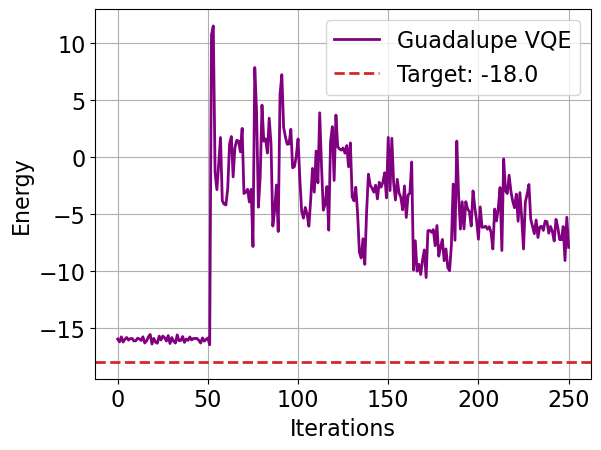

In [15]:
plt.plot(intermediate_info, color='purple', lw=2, label='Guadalupe VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
gs_energy = -18.0
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()